In [40]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.tri as tri
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline

In [49]:
results_path = '~/sims_n_results/nucmoles_opusupdate_aug2019/'
tamuNoRatio_path = results_path + 'tamuNoRatio/'
tamuRatio_path = results_path + 'tamuRatio/'
sfco_path = results_path + 'sfco/'
# Copied from scripts
uncs = [0.05, 0.1, 0.15, 0.2]
job_dirs = ['Job' + str(i) + '_unc' + str(unc) for i, unc in enumerate(uncs)]
CDF_percentiles = [0.9998, 0.9988, 0.95, 0.9, 0.5, 0.1, 0.01]

In [119]:
dfs = {}
for i, unc_job in enumerate(job_dirs):
    dfs['dfTamu' + str(i)] = pd.read_csv(tamuNoRatio_path + unc_job + '/' + unc_job + '.csv')
    dfs['dfTamuRatio' + str(i)] = pd.read_csv(tamuRatio_path + unc_job + '/' + unc_job + '.csv')
    dfs['dfSfco' + str(i)] = pd.read_csv(sfco_path + unc_job + '/' + unc_job + '.csv')
# for ease of testing things
df0 = dfs['dfTamu0']
df2 = dfs['dfSfco2']

In [81]:
dfs['dfSfco1'].columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'sim_idx', 'ReactorType', 'CoolingTime',
       'Enrichment', 'Burnup', 'OrigenReactor', 'pred_idx', 'pred_ReactorType',
       'pred_CoolingTime', 'pred_Enrichment', 'pred_Burnup',
       'pred_OrigenReactor', 'MaxLogLL', 'MaxLLUnc', '2ndMaxLogLL',
       '2ndMaxLLUnc', 'CDF_LogLL_0.9998', 'CDF_LLUnc_0.9998',
       'CDF_LogLL_0.9988', 'CDF_LLUnc_0.9988', 'CDF_LogLL_0.95',
       'CDF_LLUnc_0.95', 'CDF_LogLL_0.9', 'CDF_LLUnc_0.9', 'CDF_LogLL_0.5',
       'CDF_LLUnc_0.5', 'CDF_LogLL_0.1', 'CDF_LLUnc_0.1', 'CDF_LogLL_0.01',
       'CDF_LLUnc_0.01', 'ReactorType_Score', 'CoolingTime_Error',
       'Enrichment_Error', 'Burnup_Error', 'OrigenReactor_Score'],
      dtype='object')

In [120]:
max_ll_pred = df2['MaxLogLL'].quantile(1, interpolation='higher')
df2.loc[df2['MaxLogLL'] == max_ll_pred]

,Unnamed: 0,Unnamed: 0.1,sim_idx,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,pred_idx,pred_ReactorType,...,CDF_LLUnc_0.5,CDF_LogLL_0.1,CDF_LLUnc_0.1,CDF_LogLL_0.01,CDF_LLUnc_0.01,ReactorType_Score,CoolingTime_Error,Enrichment_Error,Burnup_Error,OrigenReactor_Score
234,24,24,NOV-4|13626135|69|135,pwr,0.0,3.592,29900.0,Novovoronezh-4_VVER-440,16405,bwr,...,21.346785,-334800.077369,14.029704,-8.480889e+08,10.406071,False,4214.608653,0.302,10131.96,False


In [121]:
max_ll_pred

-2.873949748182105

In [84]:
dfs.keys()

dict_keys(['dfTamu0', 'dfTamuRatio0', 'dfSfco0', 'dfTamu1', 'dfTamuRatio1', 'dfSfco1', 'dfTamu2', 'dfTamuRatio2', 'dfSfco2', 'dfTamu3', 'dfTamuRatio3', 'dfSfco3'])

# MLL Heatmap

In [117]:
def plot_heatmap(i, dfname):
    df = dfs['df' + dfname + str(i)]
    
    plt.clf()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    vmin = 0
    vmax = df['MaxLogLL'].quantile(1, interpolation='higher')
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    
    x = df['Burnup']
    y = df['Enrichment']#['CoolingTime']
    triang = tri.Triangulation(x, y)
    z = df['MaxLogLL']
    
    surf = ax.tripcolor(triang, z, norm=norm, cmap=cm.viridis, shading='gouraud')
    # Other potential args: edgecolor='none', linewidth=0, antialiased=False
    
    ax.set_title(str(uncs[i]*100) + '% Uncertainty', fontsize=20, pad=15)
    ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=20, labelpad=15)
    ax.set_ylabel('Cooling Time [days]', fontsize=20, labelpad=15)
    #ax.set_xlim()
    #ax.set_ylim()
    
    cbar = fig.colorbar(surf)
    cbar.ax.set_ylabel('LogLikelihood', size=20) #labelpad=15
    #ax.tick_params(labelsize=14)
    plt.show()
    
    dftitle = {'Tamu': 'tamuNoRatio', 'TamuRatio': 'tamuRatio', 'Sfco' : 'sfco'}
    fig.savefig('../plots/' + dftitle[dfname] + str(i) + '_unc' + str(uncs[i]) + '.png')

<Figure size 432x288 with 0 Axes>

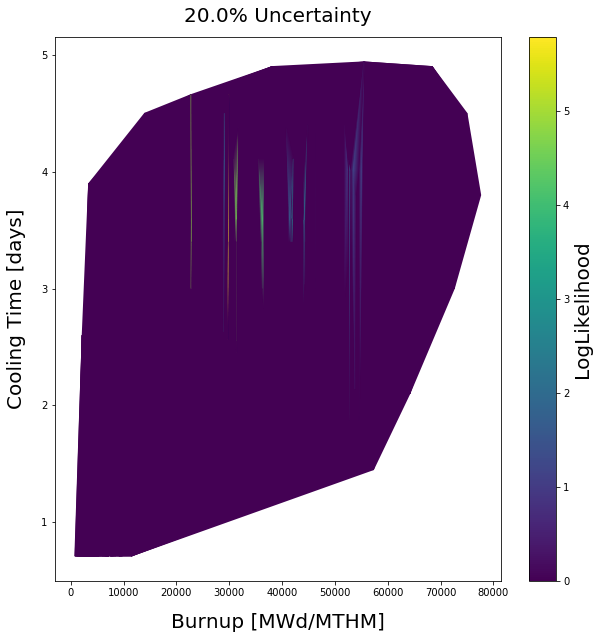

In [122]:
plot_heatmap(3, 'Sfco')

# CDFs of select predictions

In [ ]:
def plot_cdfs(df):
    
    plt.clf()
    
    err = df['Percent Error']
    knn_mean = df['kNN Score']
    knn_std = df['kNN Std']
    dtr_mean = df['DTree Score']
    dtr_std = df['DTree Std']
    svr_mean = df['SVR Score']
    svr_std = df['SVR Std']
    
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(1, 1, 1)
    
    ax.set_title('Reactor Type Prediction', fontsize=20)
    ax.set_xlabel('Percent Error', fontsize=14)
    #ax.set_xlim(0, 10)
    ax.set_ylabel('Score', fontsize=16)
    #ax.set_ylim(0.98, 1.001)
    
    ax.fill_between(err, knn_mean - knn_std, knn_mean + knn_std, color = med[0], alpha=0.2)
    ax.fill_between(err, dtr_mean - dtr_std, dtr_mean + dtr_std, color = med[1], alpha=0.2)
    ax.fill_between(err, svr_mean - svr_std, svr_mean + svr_std, color = med[2], alpha=0.2)
    
    ax.plot(err, knn_mean, 'o-', color=med[0], mew=0, ms=5, label="kNN")
    ax.plot(err, dtr_mean, 'o-', color=med[1], mew=0, ms=5, label="Decision Tree")
    ax.plot(err, svr_mean, 'o-', color=med[2], mew=0, ms=5, label="Support Vector")
    
    ax.tick_params(labelsize=14)
    ax.legend(loc='best')#'right', bbox_to_anchor=(1.4, 0.5))
    
    plt.savefig('.png', bbox_inches='tight', transparent=True)
    plt.show()

### Heatmaps snippet
norm = Normalize(vmin=zmin, vmax=zmax, clip=True)

triang = tri.Triangulation(x, y)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

surf = ax.tripcolor(triang, z, norm=norm, cmap=cm.viridis, shading='gouraud')

cbar = fig.colorbar(surf)

cbar.ax.set_ylabel('z label', size=20, labelpad=15)

ax.set_xlabel('x label', fontsize=20, labelpad=15)

ax.set_ylabel('y label', fontsize=20, labelpad=15)

ax.set_title('Title', fontsize=20, pad=15)

plt.show()